# 02 - Data from the Web


In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need! You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this brief tutorial to understand quickly how to use it.

In [1]:
from bs4 import BeautifulSoup
import requests
import json
import string
import pandas as pd
import re
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools
import unicodedata
from textblob.blob import TextBlob

%matplotlib inline

# Task 1 - QS Ranking

### Creation of the dataset

Multiple strategies have been testes in order to find the data used to construct the table on the QS Rankings webpage. We found by opening the Web Inspector on the website the different ressources used by the page. Among them a text file named 'XHR/357051.txt'  was containing the expected ranking with the desired informations. The URL_QS links to this file. We convert it to a DataFrame. From there, we delete the unneccessary columns and keep only the first 200 Universities.

In [2]:
URL_QS = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508497791260'
r = requests.get(URL_QS)
page_body = r.json()
qs_df = pd.DataFrame(page_body['data'])
qs_df = qs_df.drop(['core_id','logo','guide','cc', 'nid', 'stars','score'], axis = 1).head(200)

Additionnal informations needed to be accessed on each university webpage. We used the 'url' column, went to the university page and extracted all the number values found on the webpage. We stored the values we were interested in on new columns. In the cases where there were no/a lack of informations on the webpage, the columns are filed with NaN values.

In [3]:
# Going on each university page for each index of the table

for index_ in range(0, qs_df.shape[0]):
    
    URL_ADD = 'https://www.topuniversities.com' + qs_df.get_value(index_, 'url')
    r = requests.get(URL_ADD)
    page_body = r.text
    soup = BeautifulSoup(page_body, 'html.parser')
    # Request all numbers that are displayed on the page, we know their order
    all_numbers = soup.findAll('div', {'class' : 'number'})
    
    # If the page contains no numbers, we will store NaN
    if not all_numbers:
        total_faculty_number = np.nan
        interna_faculty_number = np.nan
        total_students_number = np.nan
        interna_students_number = np.nan
   
    else:    
    # Total Faculty Members
        total_faculty = all_numbers[0]
        total_faculty_number = int(re.sub("[^\\d]",'',str(total_faculty)))
    
    # International Faculty Members
        interna_faculty = all_numbers[1]
        interna_faculty_number = int(re.sub("[^\\d]",'',str(interna_faculty)))
    
    # Total Students
        total_students = all_numbers[2]
        total_students_number = int(re.sub("[^\\d]",'',str(total_students)))  
    
    # International Students
        if all_numbers[3] == all_numbers[0]:
            interna_students_number = np.nan
        else:
            interna_students = all_numbers[3]
            interna_students_number = int(re.sub("[^\\d]",'',str(interna_students)))
    
    # Adding the found values in the columns
    qs_df.set_value(index_, 'Faculty Members - Total', total_faculty_number)
    qs_df.set_value(index_, 'Faculty Members - International', interna_faculty_number)
    qs_df.set_value(index_, 'Nb Students - Total', total_students_number)
    qs_df.set_value(index_, 'Nb Students - International', interna_students_number)

The obtained DataFrame is presented below,

In [4]:
qs_df.head()

,country,rank_display,region,title,url,Faculty Members - Total,Faculty Members - International,Nb Students - Total,Nb Students - International
0,United States,1,North America,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...,2982.0,1679.0,11067.0,3717.0
1,United States,2,North America,Stanford University,/universities/stanford-university,4285.0,2042.0,15878.0,3611.0
2,United States,3,North America,Harvard University,/universities/harvard-university,4350.0,1311.0,22429.0,5266.0
3,United States,4,North America,California Institute of Technology (Caltech),/universities/california-institute-technology-...,953.0,350.0,2255.0,647.0
4,United Kingdom,5,Europe,University of Cambridge,/universities/university-cambridge,5490.0,2278.0,18770.0,6699.0


### Ratios computation

For the next part of the question, we need to compute two ratios for all the different universities. We define a method ratio that will return the expected value.

In [5]:
# Ratio returns a/b if both those values are defined
def ratio(a, b):
    if np.isnan(a)|np.isnan(b)|(b == 0):
        return np.nan
    else:
        return a/b

In [6]:
# Apply the ratio functions to all universities
for index, row in qs_df.iterrows():
    if np.isfinite(row['Nb Students - Total']) and np.isfinite(row['Nb Students - International']) or np.isfinite(row['Nb Students - Total']) and np.isfinite(row['Faculty Members - Total']):
        qs_df.loc[index, 'QS Ratio Int. Students'] = round(ratio(row['Nb Students - International'], row['Nb Students - Total']), 2)
        qs_df.loc[index, 'QS Ratio Students/Staff'] = round(ratio(row['Nb Students - Total'], row['Faculty Members - Total']), 2)

In [7]:
# Rename columns of the DataFrame for further processing
qs_df = qs_df.loc[ :, ['title', 'rank_display', 'country', 'region', 'QS Ratio Int. Students', 'QS Ratio Students/Staff' ]]
qs_df = qs_df.rename(index=str, columns={ "title" : "University", "rank_display": "QS rank"});
qs_df.index = np.arange(1, len(qs_df) + 1)
qs_df['QS rank'] = qs_df.index.values.tolist()

# Finding the best universities for each ratio
max_internatio_ratio_index = qs_df['QS Ratio Int. Students'].argmax()
max_internatio_ratio = qs_df['QS Ratio Int. Students'][max_internatio_ratio_index]

max_stud_staff_ratio_index = qs_df['QS Ratio Students/Staff'].argmax()
max_stud_staff_ratio = qs_df['QS Ratio Students/Staff'][max_stud_staff_ratio_index]


print("The university with the biggest ratio of international students is the", \
      qs_df.University[max_internatio_ratio_index],"with a ratio of ", max_internatio_ratio, ".\n\n")

print("The university with the biggest ratio between faculty members and students is the", \
      qs_df.University[max_stud_staff_ratio_index],"with a ratio of ", max_stud_staff_ratio, ".\n\n")

The university with the biggest ratio of international students is the London School of Economics and Political Science (LSE) with a ratio of  0.69 .


The university with the biggest ratio between faculty members and students is the Vienna University of Technology with a ratio of  24.76 .




### Plot the results

We are now aggregating the data per countries (top) and by region (bottom).

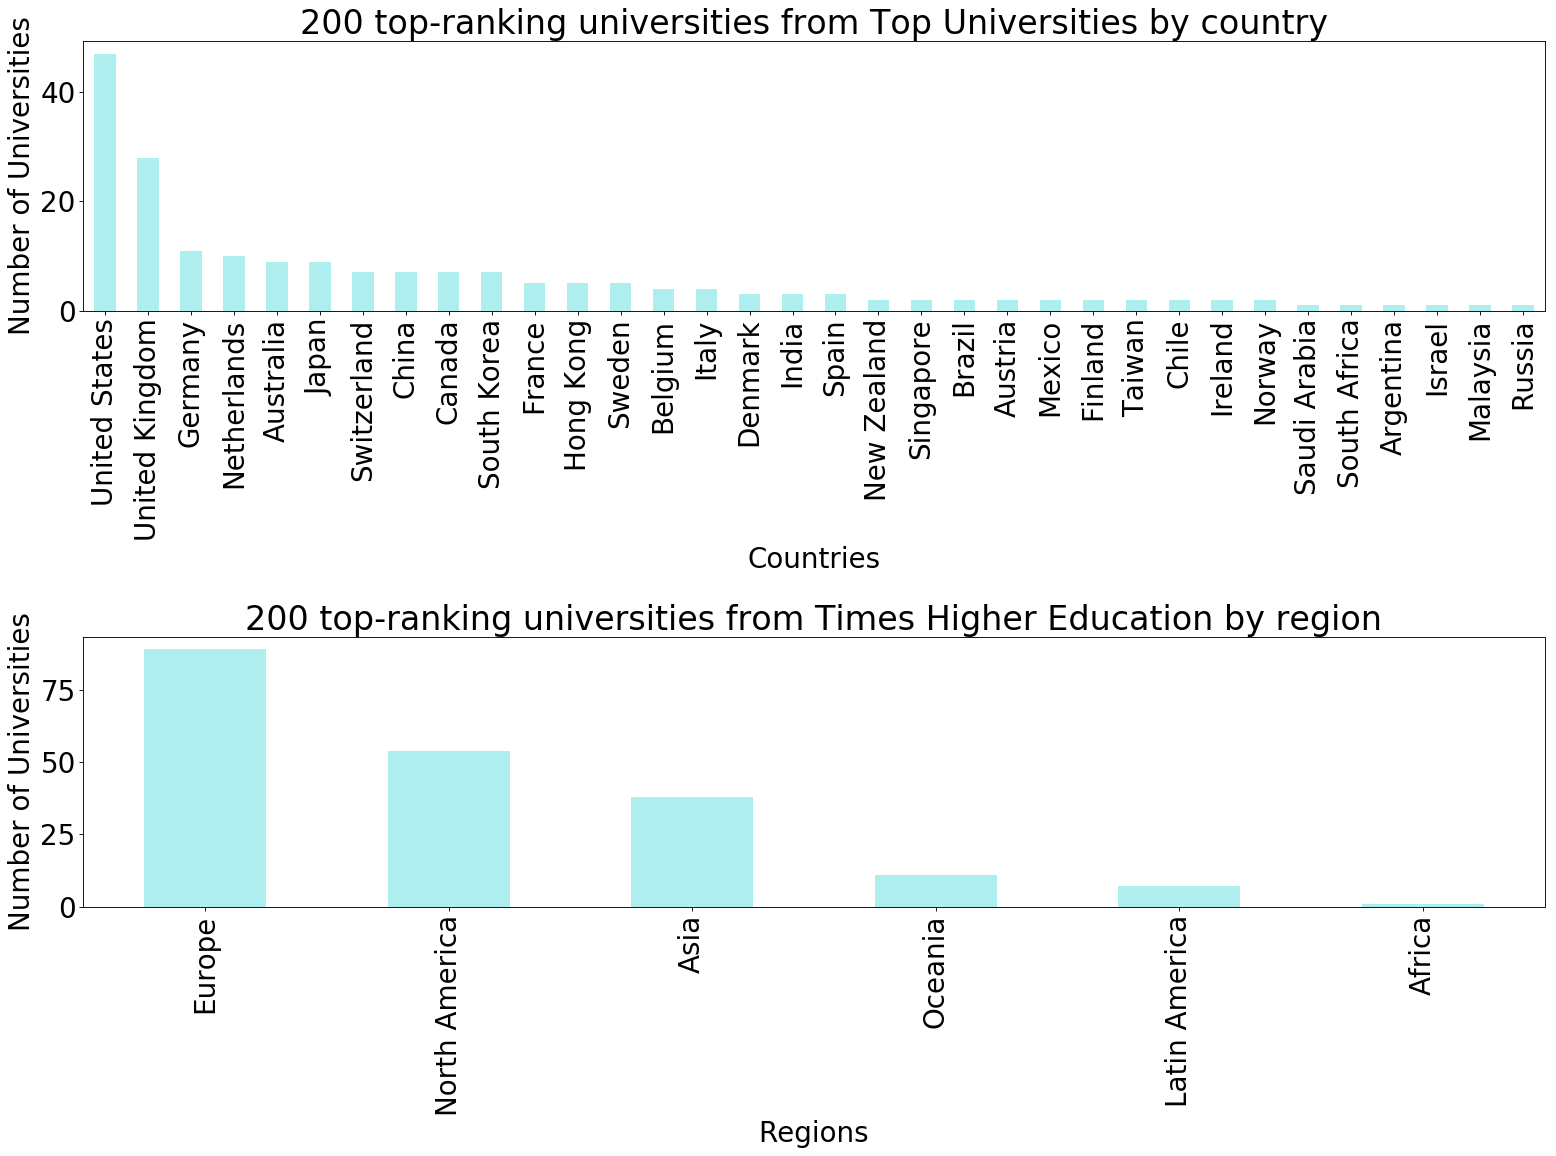

In [8]:
fig = plt.figure(figsize=(20, 15), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})

plt.subplot(2,1,1)
embarkedPlot = qs_df['country'].value_counts().plot(kind='bar', color='paleturquoise')
embarkedPlot.set_xlabel("Countries")
embarkedPlot.set_ylabel("Number of Universities")
plt.title('200 top-ranking universities from Top Universities by country')

plt.subplot(2, 1, 2)
embarkedPlot = qs_df['region'].value_counts().plot(kind='bar', color='paleturquoise')
embarkedPlot.set_xlabel("Regions")
embarkedPlot.set_ylabel("Number of Universities")
plt.title('200 top-ranking universities from Times Higher Education by region')

fig.tight_layout()

plt.show()

If we look solely to the top-universities by country, one can observe that the United States are dominating the ranking, with the United Kingdom not so far behind. However, if we look at a broader scale with the regions, we can observe that Europe is placing more universities among the top world universities. This can be explained through the sizes of the countries that will vary a lot: the United States are far bigger than any european countries. 

In [9]:
qs_df["QS Ratio Students/Staff"].fillna('NoRatio', inplace=True)
qs_df['QS Ratio Int. Students'].fillna('NoRatio', inplace=True)

# Task 2 - Times Higher Education Ranking

The same strategy as with the QS ranking was used. This time, less processing of the data was needed to extract the desired DataFrame. There was no need to access a new url for each university, therefore simplifying the code.

In [10]:
URL_THE = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
r = requests.get(URL_THE)
page_body = r.json()
the_df = pd.DataFrame(page_body['data']).head(200)

### Ratios computation

Same strategy to compute the expected ratios. The method ratio is used again. Some small processing of the DataFrame is performed to clean our results and delete the non-necessary informations. For example, the '=' values in case of a tie between university is deleted to only keep track of their position in the list as their rank. The returned DataFrame is presented below.

In [11]:
# Firts we need to remove the '%' symbol from the column "THE % International Students"
# Then we convert the string to int and we do the calculation

the_df['stats_number_students'] = pd.to_numeric(the_df['stats_number_students'].str.replace(',', ''))
the_df['stats_pc_intl_students'] = pd.to_numeric(the_df['stats_pc_intl_students'].str.replace('%', ''))

# Ratios calculation
for index, row in the_df.iterrows():
    the_df.loc[index, 'stats_pc_intl_students'] = round(row['stats_number_students']*row['stats_pc_intl_students']*0.01)
    the_df.loc[index, 'THE Ratio Int. Students'] = round(float(row['stats_pc_intl_students'])/100.0, 2)

# Rename columns for further processing
the_df = the_df.loc[ :, ['name', 'rank', 'location','THE Ratio Int. Students', 'stats_student_staff_ratio']]
the_df = the_df.rename(index=str, columns={ "name" : "University",
                                  "rank": "THE rank", "location": "country",
                                  "stats_student_staff_ratio" : "THE Ratio Students/Staff"
                                 });

# Delete the '=' from the rank and gives them rather their order in the list as rank
the_df.index = np.arange(1, len(the_df) + 1) 
the_df['THE rank'] = the_df.index.values.tolist()

the_df.head()

,University,THE rank,country,THE Ratio Int. Students,THE Ratio Students/Staff
1,University of Oxford,1,United Kingdom,0.38,11.2
2,University of Cambridge,2,United Kingdom,0.35,10.9
3,California Institute of Technology,3,United States,0.27,6.5
4,Stanford University,4,United States,0.22,7.5
5,Massachusetts Institute of Technology,5,United States,0.34,8.7


From there, we can find the best Universities for each ratio according to the THE ranking,

In [12]:
max_internatio_ratio_index = the_df['THE Ratio Int. Students'].argmax()
max_internatio_ratio = the_df['THE Ratio Int. Students'][max_internatio_ratio_index]

max_stud_staff_ratio_index = the_df['THE Ratio Students/Staff'].argmax()
max_stud_staff_ratio = the_df['THE Ratio Students/Staff'][max_stud_staff_ratio_index]


print("The university with the biggest International studient ration is the", the_df.University[max_internatio_ratio_index],
      "with a ratio of ", max_internatio_ratio, ".\n\n")

print("The university with the biggest studients/staff ratio is the", the_df.University[max_stud_staff_ratio_index],
      "with a ratio of ", max_stud_staff_ratio, ".\n\n")

The university with the biggest International studient ration is the London School of Economics and Political Science with a ratio of  0.71 .


The university with the biggest studients/staff ratio is the Cornell University with a ratio of  9.8 .




### Plot the results

Only the plot for the top-ranking universities per country is presented below. The results doesnt change much between the two rankings, expect from Japan that presents way less universities among the top 200. The region is not depicted below as the value was not appearing in the rankings informations. The best method to find the region knowing the country would be to use the merge that is created in the next question. 

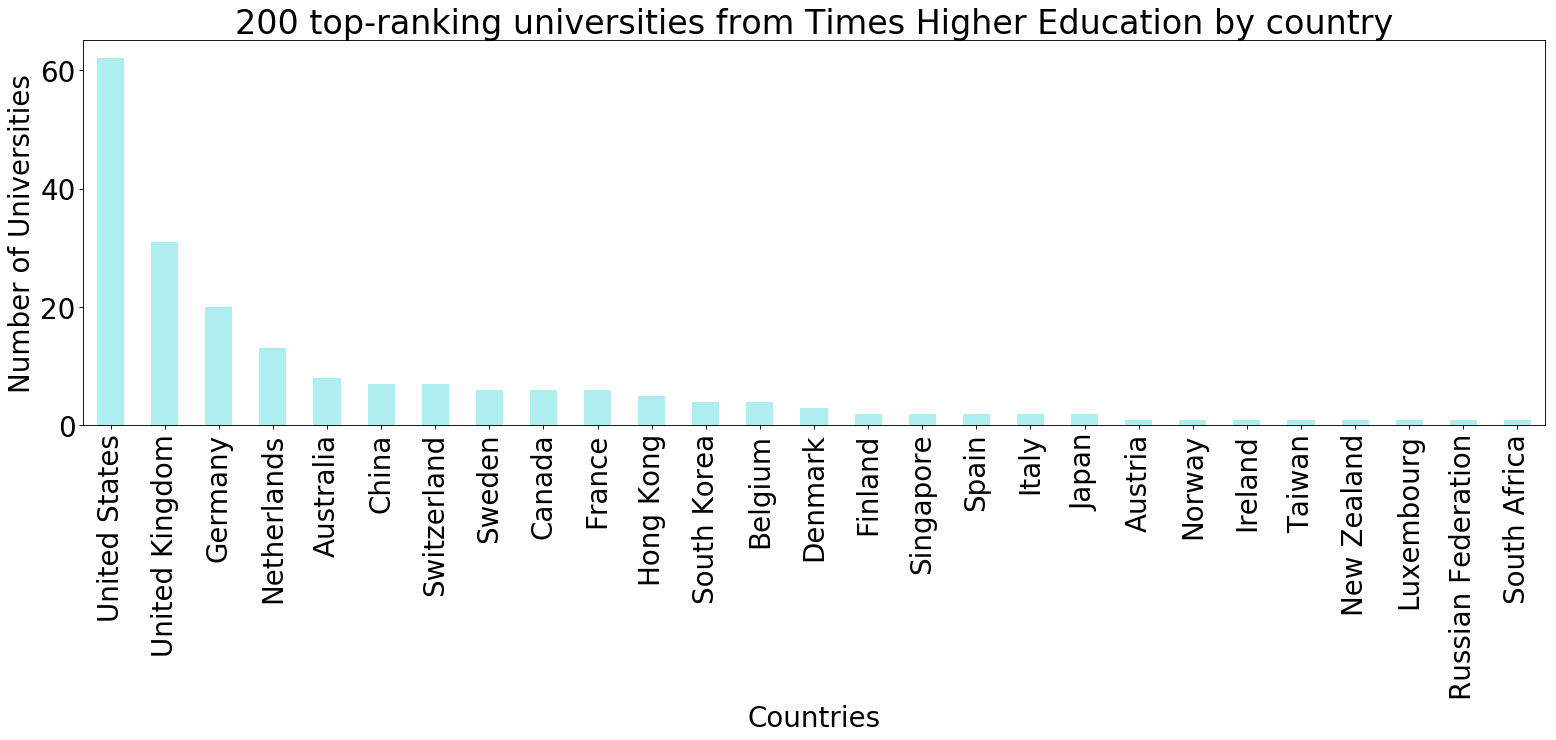

In [13]:
fig2 = plt.figure(figsize=(20, 15), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
embarkedPlot = the_df['country'].value_counts().plot(kind='bar', color='paleturquoise')
embarkedPlot.set_xlabel("Countries")
embarkedPlot.set_ylabel("Number of Universities")
plt.title('200 top-ranking universities from Times Higher Education by country')

fig2.tight_layout()

plt.show()

In [14]:
# Rename Nan value to NoRatio for a better vizualisation
the_df["THE Ratio Students/Staff"].fillna('NoRatio', inplace=True)
the_df['THE Ratio Int. Students'].fillna('NoRatio', inplace=True)

## Task 3 - Data Merging


For this task, we have to merge the two previously created DataFrames. It will be easier with the pre-processing that was already done to clean the DataFrames and gives them the same column names.

### Clean University Names

To merge both ranking, we take the university names from both ranking, then look at the name in the THE ranking and see if it is contained in a university name in the QS. When this is the case, we rename the university name with the one from the THE.

In [15]:
# Looking if the university name from the THE is contained in a university name from the QS
for index_qs, row_qs in qs_df.iterrows():
     for index_the, row_the in the_df.iterrows():
        if row_the['University'] in row_qs['University'] :
            qs_df.loc[index_qs, 'University'] = row_the['University']

In [16]:
# Method to remove the acronym of a university. For example, École Polytechnique Fédérale de Lausanne (EPFL)
def remove_acronyme(column, df):
    for index, row in df.iterrows():
        a = row[column].find('(')
        if a != -1:
            df.loc[index, column] = row[column][:a-1]
            
remove_acronyme('University', qs_df)     

We also want to remove accents in both rankings.

In [17]:
# Remove accents for QS
for index, row in qs_df.iterrows():
    en_blob = TextBlob(row['University'])
    if en_blob.detect_language() in 'fr':
        qs_df.loc[index, 'University'] = ''.join((c for c in unicodedata.normalize('NFD', row['University']) if unicodedata.category(c) != 'Mn'))
        
# Remove accent for THE
for index, row in the_df.iterrows():
    #the_df.loc[index, 'University'] = row['University'].replace('of','')
    en_blob = TextBlob(row['University'])
    if en_blob.detect_language() in 'fr':
        the_df.loc[index, 'University'] = ''.join((c for c in unicodedata.normalize('NFD', row['University']) if unicodedata.category(c) != 'Mn'))

### Translation

Some university names are displayed in their country's language.We need to translate them in order to make them correspond between the rankings.

In [18]:
for index, row in qs_df.iterrows():
    en_blob = TextBlob(row['University'])
    if en_blob.detect_language() in ['de', 'es', 'ms', 'ca', 'la', 'fr']:
        a = en_blob.translate(to='en')
        qs_df.loc[index, 'University'] = str(a)
        
for index, row in the_df.iterrows():
    en_blob = TextBlob(row['University'])
    if en_blob.detect_language() in ['de', 'es', 'ms', 'la', 'fr']:
        a = en_blob.translate(to='en')
        the_df.loc[index, 'University'] = str(a)

### Result DataFrame

We can know concatenate both DataFrames while also keeping track of both rankings.

In [19]:
# Merging along the University column
result = pd.merge(qs_df, the_df, how='outer', on='University')

# Drop and rename columns
result = result.drop(['country_x'], axis=1)
result = result.rename(index=str, columns={ "country_y" : "country"});

# Concatenation
result = pd.concat([result.filter(like='University'),
                  result.filter(items=['country', 'region']), result.filter(like='rank'), 
                  result.filter(like='Ratio Int. Students'), result.filter(like='Ratio Students/Staff')],  
                  axis=1,  
                  keys=('University', 'Location', 'Rank','Ratio Int. Students', 'Ratio Students/Staff'))

# Rename of the different columns for better clarity
result = result.rename(index=str, columns={ "QS rank" : "QS", "THE rank" : "THE", 'QS Ratio Int. Students': 'QS',
                                          'THE Ratio Int. Students': 'THE', 'QS Ratio Students/Staff' : 'QS',
                                          'THE Ratio Students/Staff' : 'THE'});

# Rename Nan value to NoMatch for a better vizualisation
result.fillna('NoMatch', inplace=True)

result.head(10)

University        Location  \
                                          University         country   
0              Massachusetts Institute of Technology   United States   
1                                Stanford University   United States   
2                                 Harvard University   United States   
3                 California Institute of Technology   United States   
4                            University of Cambridge  United Kingdom   
5                               University of Oxford  United Kingdom   
6                          University College London  United Kingdom   
7                            Imperial College London  United Kingdom   
8                              University of Chicago   United States   
9  ETH Zurich - Swiss Federal Institute of Techno...         NoMatch   

                 Rank          Ratio Int. Students           \
          region   QS      THE                  QS      THE   
0  North America    1        5                0.34     0.34   
1  North America    2        4                0.23     0.22   
2  North America    3        6                0.23     0.26   
3  North America    4        3                0.29     0.27   
4         Europe    5        2                0.36     0.35   
5         Europe    6        1                0.37     0.38   
6         Europe    7       16                0.48     0.49   
7         Europe    8        8                0.54     0.55   
8  North America    9        9                0.25     0.25   
9         Europe   10  NoMatch                0.38  NoMatch   

  Ratio Students/Staff           
                    QS      THE  
0                 3.71      8.7  
1                 3.71      7.5  
2                 5.16      8.9  
3                 2.37      6.5  
4                 3.42     10.9  
5                 2.92     11.2  
6                  4.9     10.5  
7                 4.09     11.4  
8                 5.54      6.2  
9                    8  NoMatch

We had some troubles with the name of the certain schools at time to merge. This can be explained by the fact that some names are very different from one website to another.

Notice also that, after the merge, we have more than 200 university on the datafram. It is because we have different universities on the top 200 on each website so the addition of the booth create a more longer datafram.

# Task 4 - Exploratory Analysis

We want to find the different correlations that may happen between different variables of our resulting dataset. We will plot different values among each other to find any interesting behavior. To be able to plot values along the country names and region, we assign some numbers to them.

In [20]:
# We remplace the name of country/region by a number for the plot

result_tmp = result.replace("NoMatch", np.nan).replace("NoRatio", np.nan)

countryList = result_tmp['Location']['Country'].unique()  # List the different country
countryList = [x for x in countryList if str(x) != 'nan'] # Remove Nan values
countryDict = {k: v for v, k in enumerate(countryList)}   # Transforme to dict

regionList = result_tmp['Location']['region'].unique() 
regionList = [x for x in regionList if str(x) != 'nan']
regionDict = {k: v for v, k in enumerate(regionList)}

result_tmp = result_tmp.replace({"Location": countryDict}).replace({"Location": regionDict})

KeyError: 'Country'

In [ ]:
# Plot

plt.figure(figsize=(30, 50), dpi=60, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})

plt.subplot(4,1,1)
plt.scatter(result_tmp['Rank']['QS'], result_tmp['Ratio Int. Students']['QS'], s=200, label='QS')
plt.scatter(result_tmp['Rank']['THE'], result_tmp['Ratio Int. Students']['THE'], s=200, label='THE')
plt.xlabel("Rank")
plt.legend(loc='upper right');
plt.ylabel("Ratio Int. Students")
plt.title("Ratio International/Total Students in function of the Rank")

plt.subplot(4,1,2)
plt.scatter(result_tmp['Rank']['QS'], result_tmp['Ratio Students/Staff']['QS'], s=200, label='QS')
plt.scatter(result_tmp['Rank']['THE'], result_tmp['Ratio Students/Staff']['THE'], s=200, label='THE')
plt.xlabel("Rank")
plt.xlabel("Rank")
plt.legend(loc='upper right');
plt.ylabel("Ratio Students/Staff")

plt.title("Ratio Students/Staff in function of the Rank")

plt.figure(figsize=(30,80), dpi=60, facecolor='w', edgecolor='k')

plt.subplot(4,1,3)
plt.scatter(result_tmp['Rank']['QS'], result_tmp['Location']['country'], s=200, label='QS')
plt.scatter(result_tmp['Rank']['THE'], result_tmp['Location']['country'], s=200, label='THE')
plt.xlabel("Rank")
plt.ylabel("Country")
plt.legend(loc='upper right');
plt.title("Country in function of the Rank")
plt.yticks(range(0, np.shape(countryList)[0], 1), countryList)

plt.figure(figsize=(30,40), dpi=60, facecolor='w', edgecolor='k')

plt.subplot(4,1,4)
plt.scatter(result_tmp['Rank']['QS'], result_tmp['Location']['region'], s=200, label='QS')
plt.scatter(result_tmp['Rank']['THE'], result_tmp['Location']['region'], s=200, label='THE')
plt.xlabel("Rank")
plt.legend(loc='upper right');
plt.ylabel("Region")
plt.title("Region in function of the Rank")
plt.yticks(range(0, np.shape(regionList)[0], 1), regionList)

plt.show()

We observe many different things from the plots presented above. 

By plotting the ratio of international students with the university rank, we first observe that both rankings span values in the same range. This is reassuring on the quality of the extracted values as they are consistent. Then, we observe a small tendancy to have a best university when there is more international students. This could be explained with students eager to move in a new country to a university only if it is well-ranked.

By plotting the ratio of students per faculty staff, we first observe that both rankings do not span values in the same range. Maybe both rankings don't have the same methodology to count a university staff, i.e. one may not count the administrative part but only the scientific one. Again, there is a small tendancy to have more staff per student in a well-ranked university.

Now, if we look at the country displayed depending on the rank. We may observe that the THE ranking is ranking well a lot of Universities from the United States. Not much can be seen expect from that on this graph.

If we now take into account the region, the graph displays more informations. Both Europe and North America present a great number of universities in the top 200. But North America presents a bigger density among the top 30 universities, when Europe spans mainly between the 80 to 180 ranks.

## Task 5 - Finding the Best University

It is nearly impossible to define accuratly the best university, if we want to make a certain kind of university better ranked, we could rearrange the notation of the ranking. 

In this case, we want to use the data at our disposal to find the best university according to both the QS and THE rankings. As they both span different notations method (i.e. THE gives a bigger importance to the industry income), combining them might flatten a bit their respective biases. 

To perform our calcultation, we only keep the best 6 universities from both rankings. They are the same in both, just with different orders. We want to give the best university title to the one that performs consistents results on both rankings, meaning that the university performs well on a broader range of notations.  For that, we take the average of their rankings to which we add its variance. Therefore the university which is the most stable will be rewarded.

In [ ]:
best_result = result[:6]
for index, row in best_result.iterrows():
    average = (float(row['Rank']['QS']) + float(row['Rank']['THE']))/2
    variance = (float(row['Rank']['QS'])-average)**2 + (float(row['Rank']['THE'])-average)**2
    best_result.set_value(index, 'Score Total', average + variance)

In [ ]:
best_result

With a final score of 4.0, the California Institute of Technology is the most stable university among both rankings. We will define it as our Best University.